In [37]:
# Import necessary libraries
import glob
import os
import matplotlib.pyplot as plt
import cv2
import shutil  
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import natsort
from numpy import arange, array, arctan, pi, median

# Adjust image size for plotting
plt.rcParams["figure.figsize"] = (15, 10)

# Function to update X and Y coordinates based on direction and step size
def updateXY(Xpoint, Ypoint, Direction, i):
    if Direction == 'Up':
        xl = int(Xpoint)
        yl = int(Ypoint) - i
    if Direction == 'UR':  # Up-Right
        xl = int(Xpoint) + i
        yl = int(Ypoint) - i
    if Direction == 'Right':
        xl = int(Xpoint) + i
        yl = int(Ypoint)
    if Direction == 'DR':  # Down-Right
        xl = int(Xpoint) + i
        yl = int(Ypoint) + i
    if Direction == 'Down':
        xl = int(Xpoint)
        yl = int(Ypoint) + i
    if Direction == 'DL':  # Down-Left
        xl = int(Xpoint) - i
        yl = int(Ypoint) + i
    if Direction == 'Left':
        xl = int(Xpoint) - i
        yl = int(Ypoint)
    if Direction == 'UL':  # Up-Left
        xl = int(Xpoint) - i
        yl = int(Ypoint) - i
    return (xl, yl)

# Function to enhance resolution by moving in a specified direction and gathering pixel values
def IncreaseRes2(Image, Xpoint, Ypoint, IR_Thr, Direction):
    X_next = []
    Y_next = []
    Reasons = []
    # Initialize lists to store coordinates and values
    XL_next = []
    YL_next = []
    Value_next = []
    ThereIsNoAnswer = 0
    for i in range(10):
        # Update coordinates based on direction and step size
        xl, yl = updateXY(Xpoint, Ypoint, Direction, i)
        # Store updated coordinates
        XL_next.append(xl)
        YL_next.append(yl)
        # Check if coordinates are within image boundaries
        try:
            Image[int(yl), int(xl)]
        except IndexError:
            ThereIsNoAnswer = 1
            Reasons.append('DimensionError')
            break
        # Store pixel value at updated coordinates
        Value_next.append(Image[int(yl), int(xl)])
        # Stop if pixel value is zero
        if Image[int(yl), int(xl)] == 0:
            ThereIsNoAnswer = 1
            Reasons.append('ZeroNum')
            break
        # Stop if pixel value is decreasing
        if len(Value_next) > 1 and Value_next[-2] >= Value_next[-1]:
            ThereIsNoAnswer = 1
            Reasons.append('Decreasing')
            break
        # Stop if pixel value exceeds threshold
        if Image[int(yl), int(xl)] >= IR_Thr:
            if len(Value_next) == 1:
                # Exception handling for zero or decreasing values in the wrong direction
                xl, yl = updateXY(Xpoint, Ypoint, Direction, i + 1)
                if Image[int(yl), int(xl)] == 0:
                    ThereIsNoAnswer = 1
                    Reasons.append('ZeroNum, wrong direction')
                    break
                if Value_next > Image[int(yl), int(xl)]:
                    ThereIsNoAnswer = 1
                    Reasons.append('Decreasing, wrong direction')
                    break
            Reasons.append('OK')
            break
    # Convert collected values to differential values
    Converted_Value_next = Value_next.copy()
    if ThereIsNoAnswer == 0:
        if len(Value_next) == 1:
            Converted_Value_next[0] = IR_Thr
        if len(Value_next) > 1:
            for i in range(len(Value_next) - 1):
                if Converted_Value_next[i + 1] > IR_Thr:
                    Converted_Value_next[i + 1] = IR_Thr - Value_next[i]
                    break
                Converted_Value_next[i + 1] = Value_next[i + 1] - Value_next[i]
    if ThereIsNoAnswer == 0:
        # Calculate cumulative weighted sums for X and Y coordinates
        Cumulative_Value = [XL_next[i] * Converted_Value_next[i] for i in range(len(Converted_Value_next))]
        X_next.append(np.sum(Cumulative_Value) / IR_Thr)
        Cumulative_Value = [YL_next[i] * Converted_Value_next[i] for i in range(len(Converted_Value_next))]
        Y_next.append(np.sum(Cumulative_Value) / IR_Thr)
    if ThereIsNoAnswer == 1:
        # Append zero if no valid answer is found
        X_next.append(0)
        Y_next.append(0)
        ThereIsNoAnswer = 0
    return (X_next, Y_next, Reasons)

# Simple linear function for curve fitting
def objective(x, a, b):
    return a * x + b

# Function to find X and Y positions in an image
def xy(test, y_strat, margin_horizontal=250, n_pix=20, x_thr=70, y_thr=70, y_IR_Thr=210):
    
    test_show = test.copy()
    test = 255 - test  # Invert the image for processing
    
    # Lists to store left and right pixel positions
    left_px_x_list  = []
    right_px_x_list = []
    left_px_y_list  = []
    right_px_y_list = []

    # First loop: Find leftmost and rightmost X positions where pixel values exceed threshold
    for j in range(n_pix):
        # Find leftmost X coordinate
        left_px_x = min(np.where([test[y_strat + j, :, 0] > x_thr])[1])
        # Find rightmost X coordinate
        right_px_x = max(np.where([test[y_strat + j, :, 0] > x_thr])[1])
        left_px_y, right_px_y = y_strat + j, y_strat + j
        # Mark positions on the image
        test_show[left_px_y, left_px_x, :] = [0, 0, 255]
        test_show[right_px_y, right_px_x, :] = [0, 0, 255]
        # Store positions in lists
        left_px_x_list.append(left_px_x)
        right_px_x_list.append(right_px_x)
        left_px_y_list.append(left_px_y)
        right_px_y_list.append(right_px_y)

    # Calculate average X position
    x_position = np.average(left_px_x_list + right_px_x_list)
    x_position_int = int(x_position)
    
    # Reset lists for Y position calculation
    left_px_x_list  = []
    right_px_x_list = []
    left_px_y_list  = []
    right_px_y_list = []
    Dir = 'Down'  # Direction for moving downwards

    # Second loop: Find Y positions at adjusted X coordinates
    for i in range(n_pix):
        # Find Y positions where pixel values exceed threshold
        left_px_y = min(np.where([test[:, x_position_int - margin_horizontal - i, 0] > y_thr])[1])
        right_px_y = min(np.where([test[:, x_position_int + margin_horizontal + i, 0] > y_thr])[1])
        left_px_x, right_px_x = x_position_int - margin_horizontal - i, x_position_int + margin_horizontal + i
        
        # Use IncreaseRes2 to get sub-pixel accurate Y positions
        left_px_y_subpx = IncreaseRes2(np.squeeze(test[:, :, 0]), left_px_x, left_px_y, y_IR_Thr, Dir)[1]
        right_px_y_subpx = IncreaseRes2(np.squeeze(test[:, :, 0]), right_px_x, right_px_y, y_IR_Thr, Dir)[1]
        
        # Mark positions on the image
        test_show[left_px_y, left_px_x, :] = [0, 0, 255]
        test_show[right_px_y, right_px_x, :] = [0, 0, 255]
        # Store positions in lists
        left_px_x_list.append(left_px_x)
        right_px_x_list.append(right_px_x)
        left_px_y_list += left_px_y_subpx
        right_px_y_list += right_px_y_subpx

    # Calculate average Y position and maximum Y position
    y_position = np.average(left_px_y_list + right_px_y_list)
    y_position_max = np.max(left_px_y_list + right_px_y_list)
    
    return (x_position, y_position, y_position_max, test_show)


In [38]:
#Answer This Question
HowManyFramesPerSecond=120
#What is the file address 
ad=os.path.join(os.getcwd(), 'sample analyzed')

vidcap_ad=ad+"/"+'video_name.avi'
#What is the file name
vidcap = cv2.VideoCapture(vidcap_ad)
NewFolder=ad+"/"+"Frames"
DetectedImages=ad+"/"+"DetectedImages"

In [16]:
#Convert Video to Frames. If you have frames directly, assign the frame adress to NewFolder and ad, and skip this cell.
SelectingRate=1 # Choose 1 for all frames, 2 for even frames, 3, 4, 5, etc., for intervals of that number.
success,image = vidcap.read()
count=-1
Num=0
try:
    os.makedirs(NewFolder)
except:
    shutil.rmtree(NewFolder)
    os.makedirs(NewFolder)
print('Frame Selecting+++++++++++++++++++++++++++++++++++++++++++++++++',end='\n')
while True:
    count += 1
    success,image = vidcap.read()
    if count%SelectingRate!=0:
        continue
    try:
        Num+=1
        print(Num,':',count,end=' __ ')
        #image=cv2.flip(image,1)
        cv2.imwrite(NewFolder+"\\"+"%d.tiff" % count, image)
    except:
        break

Frame Selecting+++++++++++++++++++++++++++++++++++++++++++++++++
1 : 0 __ 

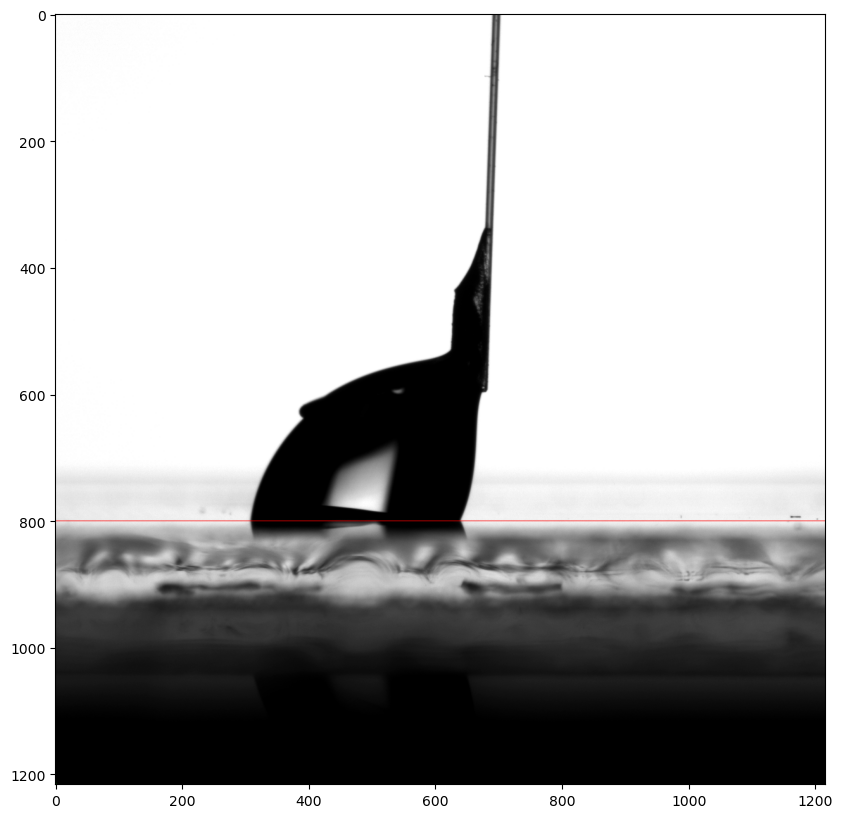

In [39]:
#Calculate for every frame

try:
    os.makedirs(DetectedImages)
except:
    shutil.rmtree(DetectedImages)
    os.makedirs(DetectedImages)  
FileName=sorted(os.listdir(NewFolder))
FileNames=[]
for i in range(len(FileName)):
    try:
        if FileName[i].split(".")[1]=="tiff":
            FileNames=FileNames+[FileName[i]]
    except:
        pass
fps=HowManyFramesPerSecond
FileNames=natsort.natsorted(FileNames)



BaseLine=800
test=cv2.imread(NewFolder+"/"+FileNames[0])
test[BaseLine,:,:]=[255,0,0]

plt.imshow(test)

In [40]:
#Without Y-axis
try:
    os.makedirs(DetectedImages)
except:
    shutil.rmtree(DetectedImages)
    os.makedirs(DetectedImages)  
FileName=sorted(os.listdir(NewFolder))
FileNames=[]
for i in range(len(FileName)):
    try:
        if FileName[i].split(".")[1]=="tiff":
            FileNames=FileNames+[FileName[i]]
    except:
        pass
fps=HowManyFramesPerSecond
FileNames=natsort.natsorted(FileNames)
RDEGREE=[]
ADEGREE=[]
RDEGREEP=[]
ADEGREEP=[]
RDEGREEV=[]
ADEGREEV=[]
file_number=[]
for FileName in FileNames:
    print(FileName,end='_')
    Img=cv2.imread(NewFolder+"/"+FileName)

    
    #Morphological transformation
    kernel = np.ones((6,6),np.uint8) #3 is maximum allowed number
    Img=cv2.morphologyEx(np.array(Img), cv2.MORPH_OPEN, kernel)
    Img=cv2.morphologyEx(np.array(Img), cv2.MORPH_CLOSE, kernel)
    #Img=cv2.morphologyEx(np.array(Img), cv2.MORPH_OPEN, kernel)
    
    HorizontalStartPoint= 0
    HorizontalEndPoint=1100
    Img_BW=Img[:,:,0]
    Img_WB=255-Img_BW
    # Crop Image
    CroppedIMg=Img_WB[BaseLine-300:BaseLine,HorizontalStartPoint:HorizontalEndPoint]
    CroppedIMg2=Img[BaseLine-300:BaseLine,HorizontalStartPoint:HorizontalEndPoint]
    # Threshold for skipping noises, Y length: how many pixels are needed?
    Thr=80   # 80-120, you can increase it to ignore noises
    YLength=10
    # Find Advancing and Receding Pixels
    X=[]
    Y=[]
    for y in np.arange(CroppedIMg.shape[0]-YLength,CroppedIMg.shape[0]):
        for x in range(CroppedIMg.shape[1]):
             if CroppedIMg[y,x] > Thr:
                #CroppedIMg2[y,x,:]=[255,0,0]
                X=X+[x]
                Y=Y+[y]
                break
    Xl=[]
    Yl=[]
    for y in np.arange(CroppedIMg.shape[0]-YLength,CroppedIMg.shape[0]):
        for x in np.arange(CroppedIMg.shape[1]-1,0,-1):
             if CroppedIMg[y,x] > Thr:
                #CroppedIMg2[y,x,:]=[255,0,0]
                Xl=Xl+[x]
                Yl=Yl+[y]
                break
    #Increase Res 
    IR_Thr=220 #220
    Dir='Right'
    X_updated=[]
    for x in range(len(X)):
        x_updated=IncreaseRes2(CroppedIMg,X[x],Y[x],IR_Thr,Dir)[0]
        X_updated=X_updated+x_updated
    Dir='Left'
    Xl_updated=[]
    for x in range(len(Xl)):
        x_updated=IncreaseRes2(CroppedIMg,Xl[x],Yl[x],IR_Thr,Dir)[0]
        Xl_updated=Xl_updated+x_updated
    popt, _ = curve_fit(objective, X_updated, max(Y)-np.array(Y))
    a, b = popt
    x_line = np.arange(min(X_updated), max(X_updated), .00001)
    y_line = objective(x_line, a, b)
    popt, _ = curve_fit(objective, Xl_updated, max(Yl)-np.array(Yl))
    a, b = popt
    xl_line = np.arange(min(Xl_updated), max(Xl_updated), .00001)
    yl_line = objective(xl_line, a, b)
       
    if len(x_line)!=0:
        dx=x_line[1]-x_line[0]
        dy=y_line[1]-y_line[0]
        gradian=arctan((dy)/(dx))
        if dy*dx<0:
            Rdegree=180+gradian*180/pi
        if dy*dx>0:
            Rdegree=gradian*180/pi
    else:
        Rdegree=90
        
    if len(xl_line)!=0: 
        dx=xl_line[1]-xl_line[0]
        dy=yl_line[1]-yl_line[0]
        gradian=arctan((dy)/(dx))
        if dx==0:
            Adegree=90
        if dy*dx<0:
            Adegree=-gradian*180/pi
        if dy*dx>0:
            Adegree=180-gradian*180/pi
    else:
        Adegree=90
        
        
    CI3=Img[BaseLine-300:BaseLine,HorizontalStartPoint:].copy()
    for x,y in zip(X_updated,Y):
        CI3[round(y),round(x)]=[0,0,255]
    for x,y in zip(Xl_updated,Yl):
        CI3[round(y),round(x)]=[0,0,255]
    
    xc1=np.mean(Xl_updated)
    yc1=np.mean(Yl)
    xc2=np.mean(X_updated)
    yc2=np.mean(Yl)
    CI3[round(yc1),round(xc1)]=[0,255,255]
    CI3[round(yc2),round(xc2)]=[0,255,255]
    cv2.imwrite(DetectedImages+'/image_'+FileName.split('.')[0]+'.tif',CI3)
    file_number.append(int(FileName.split('.')[0]))
    RDEGREE=RDEGREE+[Rdegree]
    ADEGREE=ADEGREE+[Adegree]
    
    RDEGREEP.append(np.mean(X_updated))
    ADEGREEP.append(np.mean(Xl_updated))
    
    
for i in range(len(RDEGREEP)-1):
    RDEGREEV.append(RDEGREEP[i+1]-RDEGREEP[i])
    ADEGREEV.append(ADEGREEP[i+1]-ADEGREEP[i])
RDEGREEV=(np.array(RDEGREEV)*fps)
ADEGREEV=(np.array(ADEGREEV)*fps)

DF=pd.DataFrame([np.arange(len(file_number)), file_number, RDEGREE, ADEGREE, RDEGREE, ADEGREEP, abs(np.array(RDEGREEP)-np.array(ADEGREEP))]
               , index= ["Counter", "File number", "Left angle", "Right angle",  "Left x_position",  "Right x_position", "Contact line"]).T
DF.to_excel(ad+"/"+"results.xlsx")

52.tiff_53.tiff_54.tiff_55.tiff_56.tiff_57.tiff_58.tiff_59.tiff_60.tiff_61.tiff_62.tiff_63.tiff_64.tiff_65.tiff_66.tiff_67.tiff_68.tiff_69.tiff_70.tiff_71.tiff_72.tiff_73.tiff_74.tiff_75.tiff_76.tiff_77.tiff_78.tiff_79.tiff_80.tiff_81.tiff_82.tiff_83.tiff_84.tiff_85.tiff_86.tiff_87.tiff_88.tiff_89.tiff_90.tiff_

In [34]:
DetectedImages

'/home/sajjad/Downloads/git mpip/Drop-Surface-Temporal-Profiling/sample analyzed/DetectedImages'